# Convolutional Neural Networks

## Project: Landmark Classification

---

---
In this notebook, we will take the first steps towards building models to automatically predict the location of the image based on any landmarks depicted in the image.
At the end of this project, our code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world.


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, we will create a CNN that classifies landmarks. CNN _from scratch_ (so, we can't use transfer learning _yet_!).
Test accuracy may be between 20-40 %
Although may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is.

At least accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, we will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Create three separate data loaders: one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of  data loaders is accessible via a dictionary named `loaders_scratch`.

In [ ]:
! pip install split-folders

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import splitfolders

**Data augmentation** is applied on the training set through random rotation of 10 degrees. Then again through random horizontal flipping.

In [5]:
## Specify appropriate transforms, and batch_sizes

batch_size = 28
num_workers = 0
valid_size = 0.2

#data directories
train_dir = '/content/drive/MyDrive/dataset/landmark_images/train'
test_dir = '/content/drive/MyDrive/dataset/landmark_images/test'

#defining transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms = {
    'train': transforms.Compose([transforms.RandomRotation(10),
                                           transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(p=0.2),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean, std)]),
    'test': transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)])
    }

splitfolders.ratio(train_dir, output="train_valid", seed=1337, ratio=(.8, .2), group_prefix=None)

#loading image datasets
train_data = datasets.ImageFolder('./train_valid/train', transform=transforms['train'])
valid_data = datasets.ImageFolder('./train_valid/val', transform=transforms['test'])
test_data = datasets.ImageFolder(test_dir, transform=transforms['test'])

n_classes = len(train_data.classes)
classes = [class_.split(".")[1].replace("_", " ") for class_ in train_data.classes]


#dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


Copying files: 5256 files [02:38, 33.14 files/s]


### (IMPLEMENTATION) Visualize a Batch of Training Data

The code below display some images simultaneously, and label each displayed image with its class name

to ensure that data loading and preprocessing are working as expected.

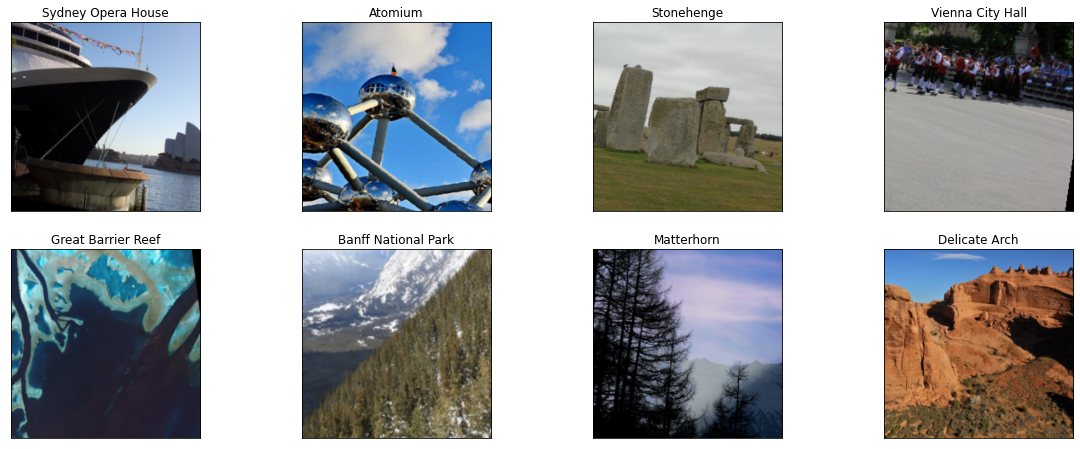

In [7]:
import random
import matplotlib.pyplot as plt
%matplotlib inline


## the class names can be accessed at the `classes` attribute (e.g., `train_dataset.classes`)

# function to un-normalize and display an image

def unnormlize(img, s, m):
    return img * s[:, None, None] + m[:, None, None]

fig = plt.figure(figsize=(20,16))
for idx in range(8):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[], )
    rand_img = random.randint(0, len(train_data))

    img = unnormlize(train_data[rand_img][0], torch.Tensor(std), torch.Tensor(mean)) # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # convert from Tensor image
    class_name = classes[train_data[rand_img][1]]
    ax.set_title(class_name)


### Initialize use_cuda variable

In [ ]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Specify a loss function and optimizer. 

In [ ]:
## loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ##optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.

In [ ]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        

        self.fc1 = nn.Linear(3 * 3 * 256, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, n_classes) # n_classes = 50
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
    
    def forward(self, x):
        ## Define forward behavior
        
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = self.pool(self.bn6(F.relu(self.conv6(x))))

        x = x.view(-1, 3 * 3 * 256)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [ ]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

### (IMPLEMENTATION) Implement the Training Algorithm


In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))



        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print("Model with validation {:.5f} saved".format(valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [ ]:
num_epochs = 10


# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()


model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.848935 	Validation Loss: 3.666016
Model with validation 3.66602 saved
Epoch: 2 	Training Loss: 3.651192 	Validation Loss: 3.465619
Model with validation 3.46562 saved
Epoch: 3 	Training Loss: 3.528215 	Validation Loss: 3.324850
Model with validation 3.32485 saved
Epoch: 4 	Training Loss: 3.413510 	Validation Loss: 3.238121
Model with validation 3.23812 saved
Epoch: 5 	Training Loss: 3.335819 	Validation Loss: 3.110633
Model with validation 3.11063 saved
Epoch: 6 	Training Loss: 3.238101 	Validation Loss: 3.008998
Model with validation 3.00900 saved
Epoch: 7 	Training Loss: 3.166206 	Validation Loss: 2.920544
Model with validation 2.92054 saved
Epoch: 8 	Training Loss: 3.117997 	Validation Loss: 2.845354
Model with validation 2.84535 saved
Epoch: 9 	Training Loss: 3.057220 	Validation Loss: 2.739965
Model with validation 2.73996 saved
Epoch: 10 	Training Loss: 2.982297 	Validation Loss: 2.711751
Model with validation 2.71175 saved


### (IMPLEMENTATION) Test the Model


In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.698178


Test Accuracy: 31% (391/1246)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

We will now use transfer learning to create a CNN .


In [ ]:
## Copy the same loaders_scratch
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Specify Loss Function and Optimizer


In [ ]:
##loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ##  optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    return optimizer

### (IMPLEMENTATION) Model Architecture


In [ ]:
model_transfer = models.vgg16(pretrained=True)
# Freeze training for all "features" layers
for parameter in model_transfer.features.parameters():
    parameter.requires_grad = False
    
# replace the final layer 
n_input = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Linear(n_input, n_classes) # n_classes = 50


if use_cuda:
    model_transfer = model_transfer.cuda()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### (IMPLEMENTATION) Train and Validate the Model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.5, verbose=1),
            ModelCheckpoint("model_transfer.pt",save_best_only=True)]

In [ ]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'
train(10, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer,
        callback, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [ ]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'
train(10, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer,
        callback, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.327507 	Validation Loss: 1.289248
Model with validation 1.28925 saved
Epoch: 2 	Training Loss: 1.447440 	Validation Loss: 1.062918
Model with validation 1.06292 saved
Epoch: 3 	Training Loss: 1.205013 	Validation Loss: 0.987893
Model with validation 0.98789 saved
Epoch: 4 	Training Loss: 1.061237 	Validation Loss: 0.935079
Model with validation 0.93508 saved
Epoch: 5 	Training Loss: 0.933279 	Validation Loss: 0.929497
Model with validation 0.92950 saved
Epoch: 6 	Training Loss: 0.843785 	Validation Loss: 0.926093
Model with validation 0.92609 saved
Epoch: 7 	Training Loss: 0.814183 	Validation Loss: 0.922095
Model with validation 0.92210 saved
Epoch: 8 	Training Loss: 0.703243 	Validation Loss: 0.919640
Model with validation 0.91964 saved
Epoch: 9 	Training Loss: 0.680951 	Validation Loss: 0.851083
Model with validation 0.85108 saved
Epoch: 10 	Training Loss: 0.641420 	Validation Loss: 0.890470


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model


In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.817087


Test Accuracy: 80% (1004/1250)


---
<a id='step3'></a>
## Step 3: Landmark Prediction Algorithm

### (IMPLEMENTATION) Part 1

Implement the function `predict_landmarks`.


In [ ]:
import cv2
from PIL import Image
from torchvision import transforms

def predict_landmarks(img_path, k):
    ## return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    img = transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()
        
    model_transfer.eval()
    output = model_transfer(img)
    top_values, top_idx = output.topk(k)

    top_classes = [classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes


# test on a sample image
predict_landmarks('/content/drive/MyDrive/dataset/landmark_images/Test_images/Eiffel_Tower.jpg', 5)

['Eiffel Tower',
 'Forth Bridge',
 'Sydney Harbour Bridge',
 'Atomium',
 'Sydney Opera House']

### (IMPLEMENTATION) Part 2

implement the function `suggest_locations`. 

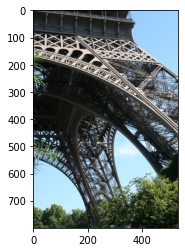

Actual Label: Eiffel Tower
Is this picture of the
 Eiffel Tower, Forth Bridge, or Sydney Harbour Bridge?


In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## display image and display landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## display image and display landmark predictions
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    print(f"Actual Label: {img_path.split('//')[1][0:].replace('_',' ').split('.')[0]}")
    print(f"Is this picture of the\n {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    
      

# test on a sample image
suggest_locations('/content/drive/MyDrive/dataset/landmark_images/Test_images//Eiffel_Tower.jpg')

### (IMPLEMENTATION) Test Your Algorithm


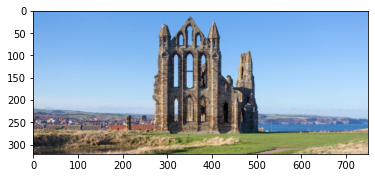

Actual Label: Whitby Abbey
Is this picture of the
 Whitby Abbey, Prague Astronomical Clock, or Edinburgh Castle?


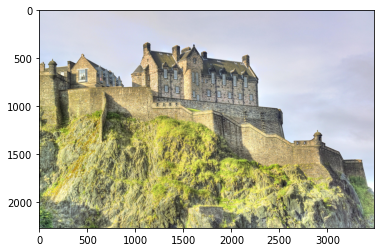

Actual Label: Edinburgh Castle
Is this picture of the
 Edinburgh Castle, Whitby Abbey, or Machu Picchu?


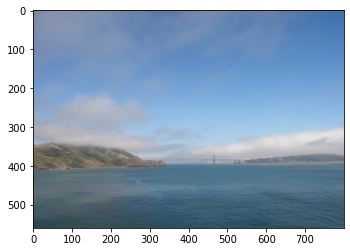

Actual Label: Golden Gate Bridge
Is this picture of the
 Golden Gate Bridge, Niagara Falls, or Dead Sea?


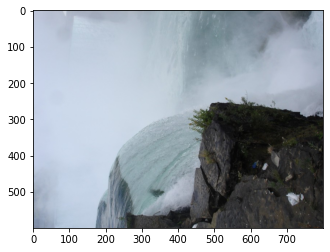

Actual Label: Niagara Falls
Is this picture of the
 Gullfoss Falls, Niagara Falls, or Yellowstone National Park?


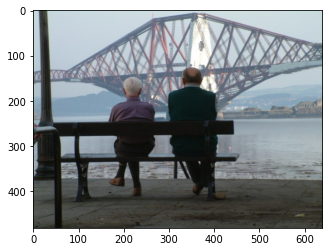

Actual Label: Forth Bridge
Is this picture of the
 Forth Bridge, Sydney Harbour Bridge, or Golden Gate Bridge?


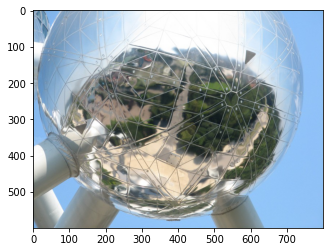

Actual Label: Atomium
Is this picture of the
 Atomium, Eiffel Tower, or Sydney Harbour Bridge?


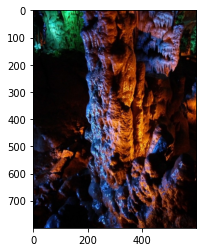

Actual Label: Soreq Cave
Is this picture of the
 Soreq Cave, Great Barrier Reef, or London Olympic Stadium?


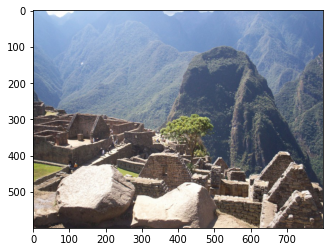

Actual Label: Machu Picchu
Is this picture of the
 Machu Picchu, Great Wall of China, or Grand Canyon?


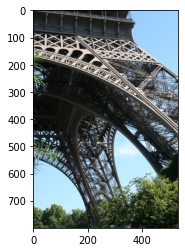

Actual Label: Eiffel Tower
Is this picture of the
 Eiffel Tower, Forth Bridge, or Sydney Harbour Bridge?


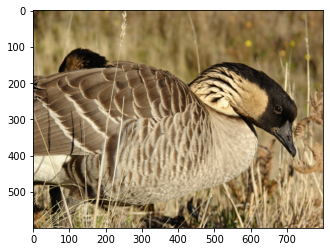

Actual Label: Haleakala National Park
Is this picture of the
 Haleakala National Park, Death Valley National Park, or Central Park?


In [ ]:
# test 10 images
import os

for path in os.listdir('/content/drive/MyDrive/dataset/landmark_images/Test_images//'):
    path = os.path.join('/content/drive/MyDrive/dataset/landmark_images/Test_images//', path)
    
    if path.lower().endswith(('.jpg')):
        suggest_locations(path)
    